In [ ]:
# Görsel işleme, model kurma ve değerlendirme için gerekenler
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Makine öğrenmesi & CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
!pip install -q kaggle


In [ ]:
from google.colab import files
files.upload()  # bilgisayarından kaggle.json dosyasını seç

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"burakcaninal","key":"0372e2f0ea7ba7006886712b288aaa9d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d borhanitrash/animal-image-classification-dataset
!unzip -q animal-image-classification-dataset.zip -d animal_dataset


Dataset URL: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset
License(s): MIT
  0% 0.00/38.4M [00:00<?, ?B/s]
100% 38.4M/38.4M [00:00<00:00, 489MB/s]


In [ ]:
import os

data_dir = "/content/animal_dataset/Animals"
classes = os.listdir(data_dir)
print("Sınıflar:", classes)

for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    print(f"{cls} sınıfı görsel sayısı:", len(os.listdir(cls_path)))


Sınıflar: ['dogs', 'snakes', 'cats']
dogs sınıfı görsel sayısı: 1000
snakes sınıfı görsel sayısı: 1000
cats sınıfı görsel sayısı: 1000


In [ ]:
image_size = (128, 128)  # tüm görselleri bu boyuta getireceğiz
X = []
y = []

for label in classes:
    class_path = os.path.join(data_dir, label)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for img_name in tqdm(image_files, desc=f"{label} sınıfı işleniyor"):
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                img = img.convert("RGB").resize(image_size)
                img_array = np.array(img)
                X.append(img_array)
                y.append(label)
        except:
            continue

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


cats sınıfı işleniyor: 100%|██████████| 1000/1000 [00:03<00:00, 296.48it/s]


X shape: (3000, 128, 128, 3)
y shape: (3000,)


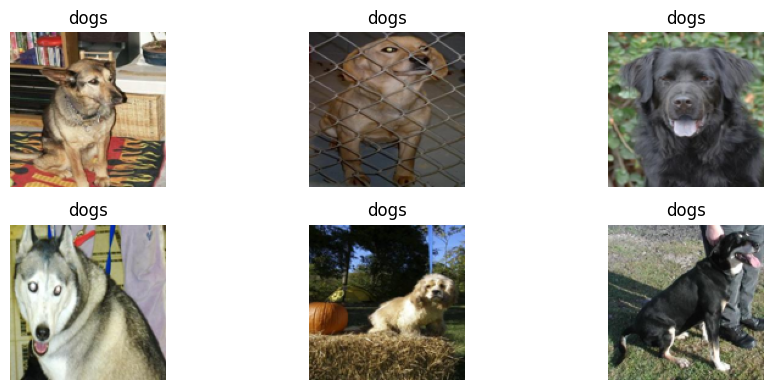

In [ ]:
plt.figure(figsize=(10, 4)) # burada örnek olarak fotoğraf yüklemesi yapıyoruz
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X[i])
    plt.title(y[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # örnekolarak: cats→0, dogs→1, snakes→2
y_categorical = to_categorical(y_encoded)

print("Orijinal sınıflar:", le.classes_)


Orijinal sınıflar: ['cats' 'dogs' 'snakes']


In [ ]:
X = X / 255.0  # Normalizasyon (0–1 arası) yapıtğımız satır

X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.3, random_state=42, stratify=y_encoded)


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 sınıf için softmax
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,051 (14.14 MB)

 Trainable params: 3,706,051 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 987ms/step - accuracy: 0.4510 - loss: 1.3196 - val_accuracy: 0.6244 - val_loss: 0.7846
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 938ms/step - accuracy: 0.6909 - loss: 0.6612 - val_accuracy: 0.6167 - val_loss: 0.8240
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 904ms/step - accuracy: 0.7523 - loss: 0.5986 - val_accuracy: 0.6956 - val_loss: 0.7077
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 77s 828ms/step - accuracy: 0.8545 - loss: 0.3691 - val_accuracy: 0.6922 - val_loss: 0.7300
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 87s 910ms/step - accuracy: 0.9299 - loss: 0.2369 - val_accuracy: 0.7000 - val_loss: 0.8000
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 924ms/step - accuracy: 0.9551 - loss: 0.1495 - val_accuracy: 0.7011 - val_loss: 0.9926
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 61s 921ms/step - accuracy: 0.9749 - loss: 0.1034 - val_accuracy: 0.7167 - val_loss: 1.0453
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 847ms/step - accuracy: 0.9850 - loss: 0.0553 - val_accu

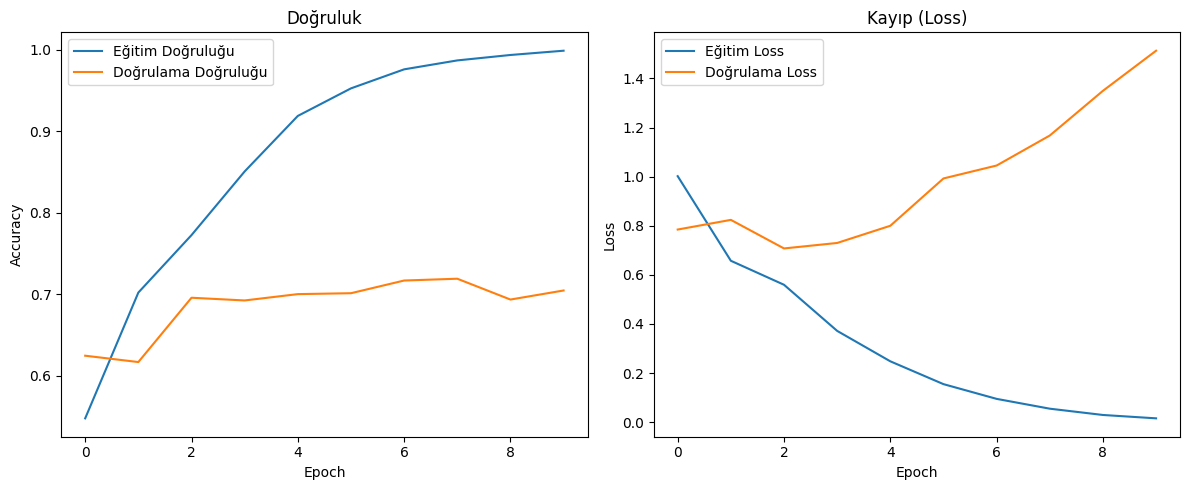

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Loss')
plt.plot(history.history['val_loss'], label='Doğrulama Loss')
plt.title('Kayıp (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Saving WhatsApp Görsel 2025-05-17 saat 00.11.28_4e35e052.jpg to WhatsApp Görsel 2025-05-17 saat 00.11.28_4e35e052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


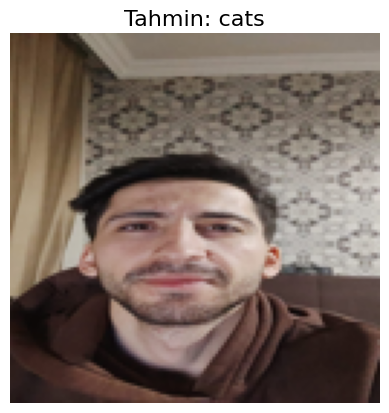

✅ Bu görsel büyük olasılıkla **CATS** sınıfına ait.


In [ ]:
from google.colab import files
from PIL import Image
import numpy as np

# 1. Görseli Yükle
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# 2. Görseli Aç, İşle
img = Image.open(img_path).convert("RGB").resize((128, 128))
img_array = np.array(img) / 255.0
img_array = img_array.reshape(1, 128, 128, 3)

# 3. Tahmin Et
prediction = model.predict(img_array)
predicted_index = np.argmax(prediction)
predicted_label = le.inverse_transform([predicted_index])[0]

# 4. Sonucu Göster
plt.imshow(img)
plt.axis('off')
plt.title(f"Tahmin: {predicted_label}", fontsize=16)
plt.show()

print(f"✅ Bu görsel büyük olasılıkla **{predicted_label.upper()}** sınıfına ait.")
